In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
class TitanicDataset(Dataset):
  def __init__(self, csv_file, train, root_dir='/data/'):
    self.root_dir = root_dir
    self.train = train
    self.titanic_X, self.titanic_y = self.preprocessing(csv_file, train)

  def preprocessing(self, csv_file, train):
    titanic_df = pd.read_csv(csv_file)
    titanic_X = titanic_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']]
    titanic_y = titanic_df['Survived']

    categorical_columns = titanic_X.select_dtypes(exclude=np.number).columns
    imp_freq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    titanic_X.loc[:, categorical_columns] = imp_freq.fit_transform(titanic_X[categorical_columns])

    numeric_columns = titanic_X.select_dtypes(include=np.number).columns
    imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
    titanic_X.loc[:, numeric_columns] = imp_mean.fit_transform(titanic_X[numeric_columns])

    X_train, X_test, y_train, y_test = train_test_split(
      titanic_X, titanic_y, test_size=0.2, random_state=42
    )

    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    if train:
       ret = pd.DataFrame(X_train), pd.DataFrame(y_train)
    else:
       ret = pd.DataFrame(X_test), pd.DataFrame(y_test)
   
    return ret

  def __len__(self):
    return len(self.titanic_X)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      return torch.Tensor(self.titanic_X.iloc[idx]), torch.Tensor(self.titanic_y.iloc[idx])

In [3]:
titanic_train = TitanicDataset('data/titanic.csv', train=True)
titanic_val = TitanicDataset('data/titanic.csv', train=False)

In [4]:
train_loader = torch.utils.data.DataLoader(
    titanic_train,
    batch_size=16, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    titanic_val,
    batch_size=16, shuffle=True)

In [5]:
class Net(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(Net, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)

  def forward(self, x):
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    m = nn.Sigmoid()
    return m(y_pred)

In [6]:
n_epochs = 50
learning_rate = 0.01
momentum = 0.5
log_interval = 10

D_in, H, D_out = 10, 3, 1

network = Net(D_in, H, D_out)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [7]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    bce = nn.BCELoss()
    loss = bce(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

In [8]:
accuracy_test = []
accuracy_train = []
test_counter = []
train_counter = []

def test(epoch):
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.round()
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  accuracy_test.append(100. * correct / len(test_loader.dataset))
  test_counter.append(epoch)

  correct = 0
  for data, target in train_loader:
      output = network(data)
      pred = output.round()
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\nTrain set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(train_loader.dataset),
    100. * correct / len(train_loader.dataset)))
  accuracy_train.append(100. * correct / len(train_loader.dataset))
  train_counter.append(epoch)

In [9]:
test(0)
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test(epoch)


Test set: Accuracy: 79/179 (44%)


Train set: Accuracy: 273/712 (38%)

Train Epoch: 1 [0/712 (0%)]	Loss: 0.699286
Train Epoch: 1 [160/712 (22%)]	Loss: 0.703420
Train Epoch: 1 [320/712 (44%)]	Loss: 0.665661
Train Epoch: 1 [480/712 (67%)]	Loss: 0.701683
Train Epoch: 1 [640/712 (89%)]	Loss: 0.700223

Test set: Accuracy: 77/179 (43%)


Train set: Accuracy: 299/712 (42%)

Train Epoch: 2 [0/712 (0%)]	Loss: 0.706897
Train Epoch: 2 [160/712 (22%)]	Loss: 0.660602
Train Epoch: 2 [320/712 (44%)]	Loss: 0.672689
Train Epoch: 2 [480/712 (67%)]	Loss: 0.658236
Train Epoch: 2 [640/712 (89%)]	Loss: 0.695556

Test set: Accuracy: 136/179 (76%)


Train set: Accuracy: 524/712 (74%)

Train Epoch: 3 [0/712 (0%)]	Loss: 0.637509
Train Epoch: 3 [160/712 (22%)]	Loss: 0.646264
Train Epoch: 3 [320/712 (44%)]	Loss: 0.649031
Train Epoch: 3 [480/712 (67%)]	Loss: 0.600506
Train Epoch: 3 [640/712 (89%)]	Loss: 0.629882

Test set: Accuracy: 133/179 (74%)


Train set: Accuracy: 549/712 (77%)

Train Epoch: 4 [0/712 (0%)]	L

Text(0, 0.5, 'accuracy')

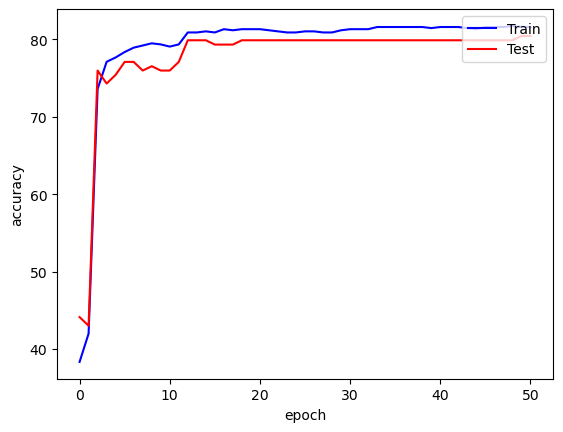

In [10]:
fig = plt.figure()
plt.plot(train_counter, accuracy_train, color='blue')
plt.plot(test_counter, accuracy_test, color='red')
plt.legend(['Train', 'Test'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [11]:
class Net2(torch.nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.linear1 = torch.nn.Linear(10, 1000)
    self.linear2 = torch.nn.Linear(1000, 1000)
    self.linear3 = torch.nn.Linear(1000, 1000)
    self.linear4 = torch.nn.Linear(1000, 1000)
    self.linear5 = torch.nn.Linear(1000, 1000)
    self.linear6 = torch.nn.Linear(1000, 1000)
    self.linear7 = torch.nn.Linear(1000, 1)

  def forward(self, x):
    h_relu = self.linear1(x).clamp(min=0)
    h_relu = self.linear2(h_relu).clamp(min=0)
    h_relu = self.linear3(h_relu).clamp(min=0)
    h_relu = self.linear4(h_relu).clamp(min=0)
    h_relu = self.linear5(h_relu).clamp(min=0)
    h_relu = self.linear6(h_relu).clamp(min=0)
    y_pred = self.linear7(h_relu)
    m = nn.Sigmoid()
    return m(y_pred)

In [12]:
network = Net2()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [13]:
accuracy_test = []
accuracy_train = []
test_counter = []
train_counter = []

test(0)
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test(epoch)


Test set: Accuracy: 74/179 (41%)


Train set: Accuracy: 268/712 (38%)

Train Epoch: 1 [0/712 (0%)]	Loss: 0.696111
Train Epoch: 1 [160/712 (22%)]	Loss: 0.692781
Train Epoch: 1 [320/712 (44%)]	Loss: 0.685486
Train Epoch: 1 [480/712 (67%)]	Loss: 0.674634
Train Epoch: 1 [640/712 (89%)]	Loss: 0.679779

Test set: Accuracy: 105/179 (59%)


Train set: Accuracy: 444/712 (62%)

Train Epoch: 2 [0/712 (0%)]	Loss: 0.662333
Train Epoch: 2 [160/712 (22%)]	Loss: 0.675957
Train Epoch: 2 [320/712 (44%)]	Loss: 0.696233
Train Epoch: 2 [480/712 (67%)]	Loss: 0.684101
Train Epoch: 2 [640/712 (89%)]	Loss: 0.683544

Test set: Accuracy: 105/179 (59%)


Train set: Accuracy: 444/712 (62%)

Train Epoch: 3 [0/712 (0%)]	Loss: 0.655097
Train Epoch: 3 [160/712 (22%)]	Loss: 0.651657
Train Epoch: 3 [320/712 (44%)]	Loss: 0.649784
Train Epoch: 3 [480/712 (67%)]	Loss: 0.608895
Train Epoch: 3 [640/712 (89%)]	Loss: 0.702755

Test set: Accuracy: 105/179 (59%)


Train set: Accuracy: 444/712 (62%)

Train Epoch: 4 [0/712 (0%)]	

Text(0, 0.5, 'accuracy')

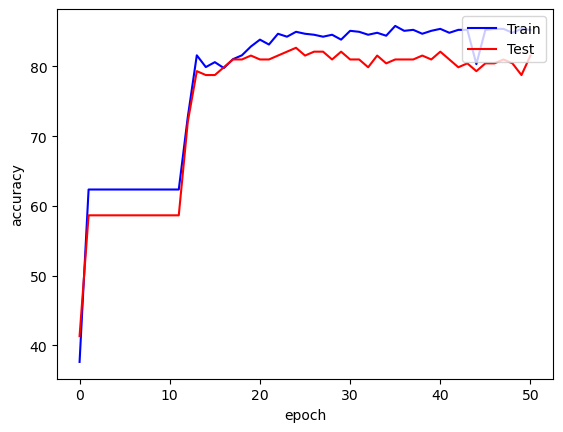

In [14]:
fig = plt.figure()
plt.plot(train_counter, accuracy_train, color='blue')
plt.plot(test_counter, accuracy_test, color='red')
plt.legend(['Train', 'Test'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [19]:
class Net3(torch.nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    self.dropout = nn.Dropout(0.5)
    self.linear1 = torch.nn.Linear(10, 1000)
    self.linear2 = torch.nn.Linear(1000, 1000)
    self.linear3 = torch.nn.Linear(1000, 1000)
    self.linear4 = torch.nn.Linear(1000, 1000)
    self.linear5 = torch.nn.Linear(1000, 1000)
    self.linear6 = torch.nn.Linear(1000, 1000)
    self.linear7 = torch.nn.Linear(1000, 1)

  def forward(self, x):
    h_relu = self.dropout(x)
    h_relu = self.linear1(h_relu).clamp(min=0)
    h_relu = self.linear2(h_relu).clamp(min=0)
    h_relu = self.linear3(h_relu).clamp(min=0)
    h_relu = self.linear4(h_relu).clamp(min=0)
    h_relu = self.linear5(h_relu).clamp(min=0)
    h_relu = self.linear6(h_relu).clamp(min=0)
    y_pred = self.linear7(h_relu)
    m = nn.Sigmoid()
    return m(y_pred)

In [20]:
network = Net3()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [21]:
accuracy_test = []
accuracy_train = []
test_counter = []
train_counter = []

test(0)
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test(epoch)


Test set: Accuracy: 74/179 (41%)


Train set: Accuracy: 268/712 (38%)

Train Epoch: 1 [0/712 (0%)]	Loss: 0.698153
Train Epoch: 1 [160/712 (22%)]	Loss: 0.687865
Train Epoch: 1 [320/712 (44%)]	Loss: 0.681502
Train Epoch: 1 [480/712 (67%)]	Loss: 0.700192
Train Epoch: 1 [640/712 (89%)]	Loss: 0.673645

Test set: Accuracy: 105/179 (59%)


Train set: Accuracy: 444/712 (62%)

Train Epoch: 2 [0/712 (0%)]	Loss: 0.680162
Train Epoch: 2 [160/712 (22%)]	Loss: 0.696408
Train Epoch: 2 [320/712 (44%)]	Loss: 0.665614
Train Epoch: 2 [480/712 (67%)]	Loss: 0.661370
Train Epoch: 2 [640/712 (89%)]	Loss: 0.670198

Test set: Accuracy: 105/179 (59%)


Train set: Accuracy: 444/712 (62%)

Train Epoch: 3 [0/712 (0%)]	Loss: 0.642431
Train Epoch: 3 [160/712 (22%)]	Loss: 0.667270
Train Epoch: 3 [320/712 (44%)]	Loss: 0.649652
Train Epoch: 3 [480/712 (67%)]	Loss: 0.720947
Train Epoch: 3 [640/712 (89%)]	Loss: 0.702723

Test set: Accuracy: 105/179 (59%)


Train set: Accuracy: 444/712 (62%)

Train Epoch: 4 [0/712 (0%)]	

Text(0, 0.5, 'accuracy')

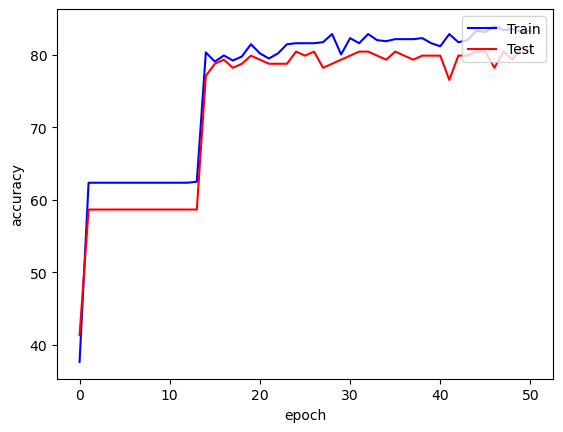

In [22]:
fig = plt.figure()
plt.plot(train_counter, accuracy_train, color='blue')
plt.plot(test_counter, accuracy_test, color='red')
plt.legend(['Train', 'Test'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')